# Pymagicc Usage Examples

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16, 9

In [2]:
# NBVAL_IGNORE_OUTPUT
import pymagicc

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from pymagicc import rcp26, rcp45, rcp60, rcp85, scenarios

## Scenarios

The four RCP scenarios are already preloaded as DataFrames in pyhector. They contain the following emissions:


In [4]:
rcp26["WORLD"].columns

Index(['FossilCO2', 'OtherCO2', 'CH4', 'N2O', 'SOx', 'CO', 'NMVOC', 'NOx',
       'BC', 'OC', 'NH3', 'CF4', 'C2F6', 'C6F14', 'HFC23', 'HFC32', 'HFC43-10',
       'HFC125', 'HFC134a', 'HFC143a', 'HFC227ea', 'HFC245fa', 'SF6'],
      dtype='object')

They are split up in regions:

In [5]:
rcp26.keys()

dict_keys(['WORLD', 'R5OECD', 'R5REF', 'R5ASIA', 'R5MAF', 'R5LAM', 'BUNKERS'])

In [6]:
rcp26["WORLD"].head()

,FossilCO2,OtherCO2,CH4,N2O,SOx,CO,NMVOC,NOx,BC,OC,...,C6F14,HFC23,HFC32,HFC43-10,HFC125,HFC134a,HFC143a,HFC227ea,HFC245fa,SF6
YEARS,,,,,,,,,,,,,,,,,,,,,
2000,6.735,1.1488,300.2070,7.4567,53.8413,1068.0009,210.6230,38.1623,7.8048,35.5434,...,0.4624,10.3949,4.0000,0.0000,8.5381,75.0394,6.2341,1.951,17.9257,5.5382
2001,6.896,1.1320,303.4093,7.5029,54.4192,1066.7447,211.5938,38.2888,7.8946,35.7143,...,0.4651,10.4328,5.3987,0.6470,9.0301,84.0409,7.4947,1.645,19.7183,5.6990
2002,6.949,1.2317,306.5787,7.5487,54.9960,1065.4692,212.5632,38.4153,7.9841,35.8846,...,0.4058,10.4708,6.7974,1.2941,9.8853,94.7162,8.7389,2.508,21.5109,5.8596
2003,7.286,1.2256,309.7165,7.5942,55.5716,1064.1742,213.5311,38.5418,8.0734,36.0543,...,0.3939,10.5083,8.1961,1.9411,12.0788,101.4157,9.9776,3.341,23.3034,6.0202
2004,7.672,1.2428,312.8241,7.6394,56.1461,1062.8596,214.4977,38.6683,8.1624,36.2233,...,0.4062,10.5455,9.5948,2.5881,12.5074,113.9297,11.2136,4.269,25.0960,6.1806


They have the following units:

In [7]:
pymagicc.units

{'BC': 'Mt',
 'C2F6': 'kt',
 'C6F14': 'kt',
 'CF4': 'kt',
 'CH4': 'MtCH4',
 'CO': 'MtCO',
 'FossilCO2': 'GtC',
 'HFC125': 'kt',
 'HFC134a': 'kt',
 'HFC143a': 'kt',
 'HFC227ea': 'kt',
 'HFC23': 'kt',
 'HFC245fa': 'kt',
 'HFC32': 'kt',
 'HFC43-10': 'kt',
 'N2O': 'MtN2O-N',
 'NH3': 'MtN',
 'NMVOC': 'Mt',
 'NOx': 'MtN',
 'OC': 'Mt',
 'OtherCO2': 'GtC',
 'SF6': 'kt',
 'SOx': 'MtS',
 'YEARS': 'Yrs'}

A plot of four categories in RCP3PD

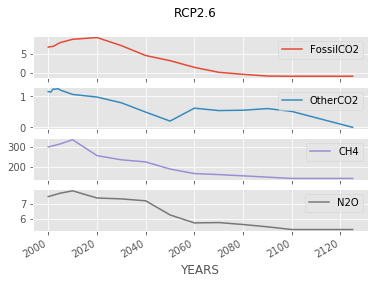

In [8]:
emissions = ["FossilCO2", "OtherCO2", "CH4", "N2O"]
rcp26["WORLD"][emissions].loc[:2150].plot(subplots=True);
plt.suptitle("RCP2.6");

Fossil fuel emissions for the four RCP scenarios.

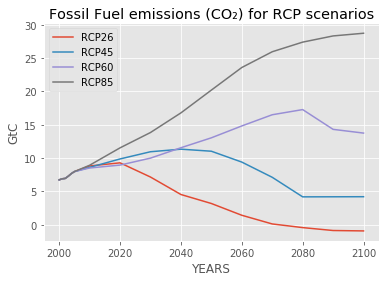

In [9]:
for name, scen in scenarios.items():
    scen["WORLD"].loc[:2100].FossilCO2.plot(label=name)
plt.legend()
plt.ylabel(pymagicc.units["FossilCO2"])
plt.title("Fossil Fuel emissions (CO₂) for RCP scenarios");

## Running MAGICC

A single `pymagicc` run doesn't take long and returns a Pandas Dict.
(If not on Windows, the very first run might be slower due to setting up Wine.)

In [10]:
# NBVAL_IGNORE_OUTPUT
%time results = pymagicc.run(rcp26)

CPU times: user 1.68 s, sys: 97.5 ms, total: 1.78 s
Wall time: 2.76 s


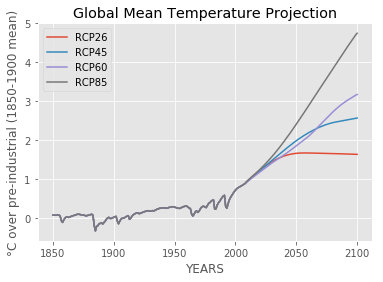

In [11]:
for name, scen in scenarios.items():
    results = pymagicc.run(scen)
    temp = (results["SURFACE_TEMP"].GLOBAL.loc[1850:] - 
            results["SURFACE_TEMP"].GLOBAL.loc[1850:1900].mean())
    temp.plot(label=name)
plt.legend()
plt.title("Global Mean Temperature Projection")
plt.ylabel("°C over pre-industrial (1850-1900 mean)");
    

The default parameters are the ones that were used to produce the RCP GHG concentrations (see also http://live.magicc.org/). Of course it's easy to change them.

In [12]:
low = pymagicc.run(rcp45, core_climatesensitivity=1.5)
default = pymagicc.run(rcp45, core_climatesensitivity=3)
high = pymagicc.run(rcp45, core_climatesensitivity=4.5)

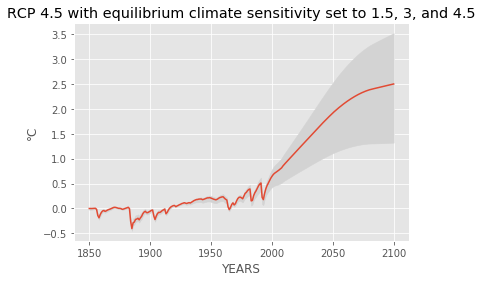

In [13]:
sel = slice(1850, 2100)
plt.fill_between(low["SURFACE_TEMP"].loc[sel].index,
                 low["SURFACE_TEMP"].loc[sel].GLOBAL,
                 high["SURFACE_TEMP"].loc[sel].GLOBAL,
                 color="lightgray")
default["SURFACE_TEMP"].loc[sel].GLOBAL.plot()
plt.title(
    "RCP 4.5 with equilibrium climate sensitivity set to 1.5, 3, and 4.5"
)
plt.ylabel("°C");
